In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import os, shutil
import glob
from PIL import Image

# Gaussian density function

The Gaussian density function given the distribution's mean $\mu$ and covariance $\sigma$ 

In [312]:
def multivariate_normal_pdf(X, mu, sigma):
    """
    Computes the multivariate normal pdf
    """
    d = X.shape[1]
    X_mu = X - mu
    inv_sigma = np.linalg.inv(sigma)
    det_sigma = np.linalg.det(sigma)
    return (np.exp(-0.5 * np.sum(np.dot(X_mu, inv_sigma) * X_mu, axis=1)) / np.sqrt((2 * np.pi) ** d * det_sigma)).reshape(-1, 1)

In [313]:
# Test multivariate_normal_pdf

x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = multivariate_normal_pdf(x0, mu, cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [314]:
def initialize_params(X, n_clusters):
    """
    Initializes the parameters for the EM algorithm
    """
    clusters = []

    # Initialize the parameters for each cluster
    for i in range(n_clusters):
        temp = np.eye(X.shape[1])
        temp[np.diag_indices_from(temp)] += 1e-6        # Add a small value to the diagonal to make the matrix invertible
        
        clusters.append({
            "mu": np.random.rand(X.shape[1]),
            "sigma": temp,
            "pi": 1 / n_clusters
        })
    
    return clusters

In [ ]:
def visualize(X, clusters):
    global dir
    global fig_count

    if not os.path.exists(dir):
        os.mkdir("Plots")

    fig = plt.figure(figsize=(5, 5), num=1)
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c='b', marker='o', s=40, alpha=0.5)
    ax.set_title('clusters = %d' % len(clusters))

    x, y = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.01, np.min(X[:, 1]):np.max(X[:, 1]):.01]
    pos = np.dstack((x, y))

    for i in range(len(clusters)):
        ax.contour(x, y, mvn.pdf(pos, clusters[i]["mu"], clusters[i]["sigma"]), alpha=0.3)
        ax.scatter(clusters[i]["mu"][0], clusters[i]["mu"][1], c='r', marker='x', s=40, alpha=0.5)

    # plt.pause(0.005)
    # plt.show()
    plt.savefig(dir + "/%d.png" % fig_count)
    fig.clf()
    fig_count += 1

In [ ]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("EM.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

In [315]:
def expectation_step(X, clusters):
    """
    Performs the expectation step of the EM algorithm
    """
    # Compute the responsibilities
    global cluster_prob, prob_sum
    cluster_prob = np.zeros((X.shape[0], len(clusters)))
    for k, cluster in enumerate(clusters):
        cluster_prob[:, k] = cluster["pi"] * mvn.pdf(X, cluster["mu"], cluster["sigma"]).reshape(-1)
    
    prob_sum = np.sum(cluster_prob, axis=1)
    cluster_prob /= prob_sum.reshape(-1, 1)

In [333]:
def maximization_step(X, clusters, k_star=False):
    """
    Performs the maximization step of the EM algorithm
    """
    global cluster_prob
    N = X.shape[0]      # number of data points

    for k, cluster in enumerate(clusters):
        # Update the parameters
        N_k = np.sum(cluster_prob[:, k])
        cluster["pi"] = N_k / N
        cluster["mu"] = np.sum(cluster_prob[:, k].reshape(-1, 1) * X, axis=0) / N_k
        cluster["sigma"] = (cluster_prob[:, k].reshape(-1, 1) * (X - cluster["mu"])).T @ (X - cluster["mu"]) / N_k
        cluster["sigma"][np.diag_indices_from(cluster["sigma"])] += 1e-6        # Add a small value to the diagonal to make the matrix invertible

        if k_star:
            visualize(X, clusters)

In [317]:
def log_likelihood(X, clusters):
    """
    Computes the log likelihood of the data given the clusters
    """
    global cluster_prob, prob_sum
    return np.sum(np.log(prob_sum))

In [318]:
def train(X, n_clusters=3, n_epochs=100):
    """
    Trains the EM algorithm
    """
    clusters = initialize_params(X, n_clusters)
    log_likelihoods = []

    for i in range(n_epochs):
        expectation_step(X, clusters)
        maximization_step(X, clusters)
        likelihood = log_likelihood(X, clusters)
        log_likelihoods.append(likelihood)

        # print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    return clusters, log_likelihoods

In [319]:
def find_k_star(log_likelihoods):
    """
    Finds the optimal number of clusters
    """
    k_star = -1
    max_diff = 0

    for i in range(1, len(log_likelihoods) - 1):
        diff = log_likelihoods[i] - log_likelihoods[i + 1]
        if diff > max_diff:
            max_diff = diff
            k_star = i + 1

    if k_star == -1:
        k_star = len(log_likelihoods) - 1
        
    return k_star

In [320]:
def run_EM_algorithm(X, n_clusters, n_epochs):
    """
    Runs the EM algorithm
    """
    converged_log_likelihood = []
    
    # Train the model for each k
    for i in range(n_clusters):
        clusters, log_likelihoods = train(X, i+1, n_epochs)
        converged_log_likelihood.append(log_likelihoods[-1])

        # # plot the log likelihoods for a given k (epoch vs log likelihood)
        # print("----------Number of clusters: %d ----------" % (i+1))
        # plt.figure(figsize=(3, 3))
        # plt.title('k = %d' % (i + 1))
        # plt.xlabel('Epoch')
        # plt.ylabel('Log likelihood')
        # plt.plot(np.arange(1, n_epochs + 1), log_likelihoods)
        # plt.show()


    # Print the converged log likelihoods for each k
    # for i in range(len(converged_log_likelihood)):
    #     print("Log likelihood for k = %d: %.2f" % (i + 1, converged_log_likelihood[i]))

    # Plot the log likelihoods for each k
    plt.figure(figsize=(5, 5))
    plt.title('Converged log likelihood')
    plt.xlabel('k')
    plt.ylabel('Log likelihood')
    plt.plot(np.arange(1, n_clusters + 1), converged_log_likelihood)
    plt.show()

    # Find the optimal number of clusters
    k_star = find_k_star(converged_log_likelihood)
    print("Optimal number of clusters: %d" % k_star)
    
    return k_star

In [322]:
def train_with_kstar(X, k_star, n_epochs=100):
    """
    Trains the EM algorithm
    params:
        X: data points
        k_star: optimal number of clusters
        n_epochs: number of epochs
    """
    clusters = initialize_params(X, k_star)
    visualize(X, clusters)

    # log_likelihoods = []

    for i in range(n_epochs):
        expectation(X, clusters)
        maximization(X, clusters, k_star=True)
        # likelihood = log_likelihood(X, clusters)
        # log_likelihoods.append(likelihood)

    # return clusters, log_likelihoods

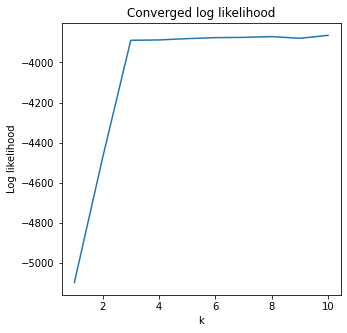

Optimal number of clusters: 8


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'Plots\\0.png'

In [352]:
#### ----------------- Main ----------------- ####

data_path = "data6D.txt"
X = np.loadtxt(data_path)

n_clusters = 10
n_epochs = 50
k_star = run_EM_algorithm(X, n_clusters, n_epochs)

# ----------- Training with k* ----------- #
if X.shape[1] == 2:
    global dir
    dir = "Plots"

    global fig_count
    fig_count = 0

    train_with_kstar(X, k_star, n_epochs)
    make_gif(dir)

401
